# Logistic Regression Exercise

Now it's your turn to implement logistic regression on a new data set. For this purpose we use the Titanic Dataset. It includes personal information of all passengers on the Titanic as well as they survived the sinking of the Titanic or died.

Here’s the **Data Dictionary** of the dataset:

- PassengerID: type should be integers

- Survived: survived or not

- Pclass: class of Travel of every passenger

- Name: the name of the passenger

- Sex: gender

- Age: age of passengers

- SibSp: No. of siblings/spouse aboard

- Parch: No. of parent/child aboard

- Ticket: Ticket number

- Fare: what Prices they paid

- Cabin: cabin number

- Embarked: the port in which a passenger has embarked.

        - C: Cherbourg , S: Southampton , Q: Queenstown


You will find the data in the data folder (it's a zip folder, so you first have to unzip it).


## What you should do:

- conduct a brief EDA to become familiar with the data
- use Logistic Regression to predict if a passenger died or not

## How to do it:

Time is short, so aim for the simplest viable product first:
- Load the data

- Get a quick overview of the data

- Agree on a classification metric for the task 

- Create a simple heuristic/educated guess for the classification first. This is called a "baseline model". It is used to compare more complex models later (in this case: logistic regression). You as a data scientist want to prove how much your work/ML could improve the business metric, therefore you need a baseline model for comparison. In some cases you want to improve on an already existing model in your company which would be your baseline model then. In other cases, there are typical baseline models used in the specific field. For other tasks, you have to come up with a simple but meaningful idea, how to classify the data based on your business understanding (EDA). A baseline model should follow Occam’s Razor principle: "A simple model is the best model". 
    - Example of a baseline model: 
    If the task is to classify cats and dogs, a baseline model could be: We classify every animal as cat if its weight < 5 kg, otherwise the animal is classified as a dog. (The value of 5 kg is an educated guess, based on our business understanding/EDA.) 

- use one or two already numerical features to create a simple first model
    -  did it even beat your base model?

- Now you can go through the data science lifecycle again and again:
    - clean the data better

    - get more insights with EDA

    - add more features

    - do feature engineering 
    
    and check if your work improves your model further!

- Stop whenever time is up or you cannot improve your model any further.

The next notebook contains a solution to this problem. If you want to compare your final result with the result of this notebook, choose **25** as random seed and a test size of 30% for your train test split.

In [19]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (11, 7)

In [2]:
# Import data from sklearn.datasets
titanic_data = pd.read_csv('data/titanic.csv')

titanic_data = titanic_data.drop(columns=['PassengerId','Name','Ticket','Cabin'], axis=1)

titanic_data.isnull().sum()



Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [3]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [4]:
# Replace missing values in age column
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

C:\Users\email\AppData\Local\Temp\ipykernel_29876\3837342890.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Age = cols[0]
C:\Users\email\AppData\Local\Temp\ipykernel_29876\3837342890.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [5]:
# Drop rows with missing values in Embarkment column
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [6]:
# One-hot-encode sex column
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
# Drop original columns for sex and embarked
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
# Conatenate the replaced ones
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


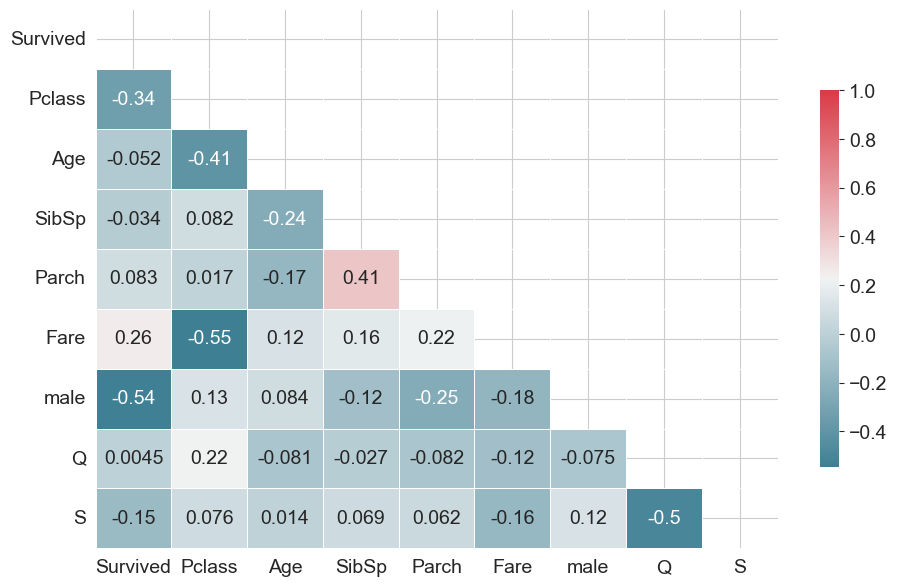

In [7]:
# Compute correlations
correlations = titanic_dmy.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=1, annot=True,
            linewidths=.5, cbar_kws={"shrink": .7});

In [9]:
# Fare and Pclass are not independent of each other, so I am going to drop one of these. 
titanic_dmy.drop(['Fare'] ,axis=1,inplace=True)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,male,Q,S
0,0,3,22.0,1,0,True,False,True
1,1,1,38.0,1,0,False,False,False
2,1,3,26.0,0,0,False,False,True
3,1,1,35.0,1,0,False,False,True
4,0,3,35.0,0,0,True,False,True


In [10]:
# Define features and target variable
X = titanic_dmy.drop("Survived", axis=1)
y = titanic_dmy.iloc[:,0].values

In [11]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

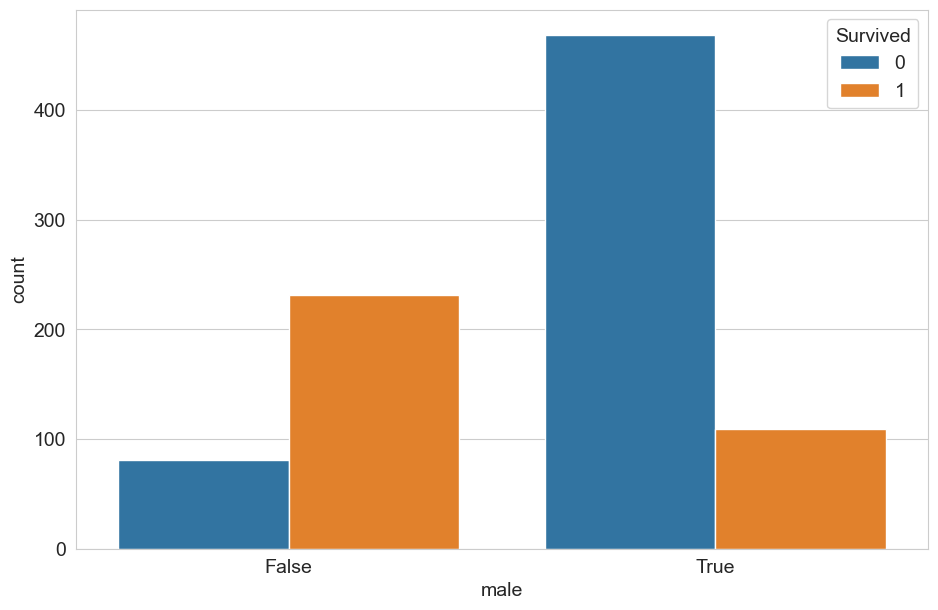

In [13]:
sns.countplot(x="male", data=titanic_dmy, hue="Survived");

In [15]:
# Instantiate model and fit it on train data
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [16]:
# Make predictions for test set
y_pred = logreg.predict(X_test)

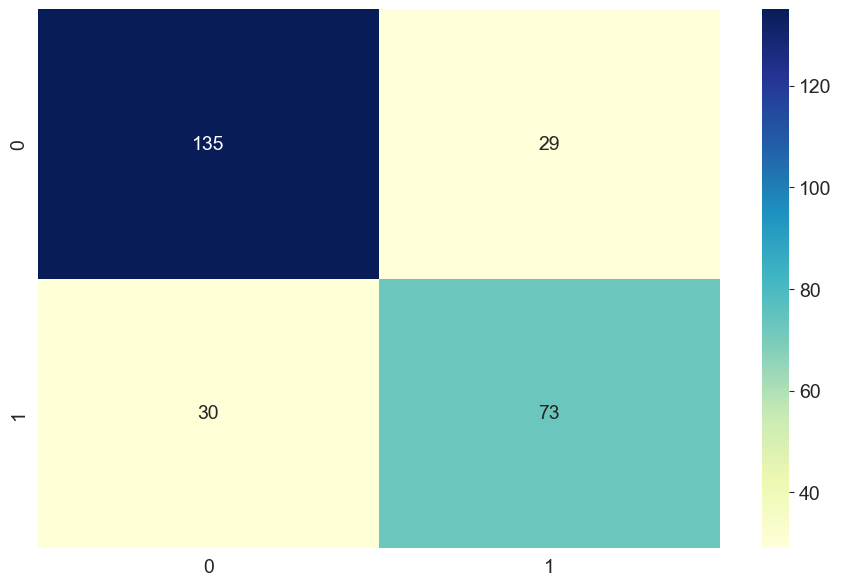

In [17]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="YlGnBu", annot=True, fmt='d');

In [21]:
# Calculate f1-score for baseline model
print("F1-score: ", f1_score(y_test, y_pred))

F1-score:  0.7121951219512195


In [22]:
# Print classification report for more information
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       164
           1       0.72      0.71      0.71       103

    accuracy                           0.78       267
   macro avg       0.77      0.77      0.77       267
weighted avg       0.78      0.78      0.78       267



In [24]:
print(logreg.coef_)
print(logreg.intercept_)

[[-1.28252265 -0.05156665 -0.27729586 -0.01706719 -2.71467006 -0.32604283
  -0.46838759]]
[6.09100772]
